# Showcase of FedLeak: Resize Generator

Here is the sanity check on if FedLeak has been correctly trasferred.

We evaluate it with the code in `attack.py`, which we named as the ***show case***.

Codes are aligned with `attack.py`, with `resize_generator.py` introduced.

Expected PSNR in $5$ times: $[22.894, 22.189, 21.990, 22.228, 22.380]$

### 🚩 1. Utils Importing

In [1]:
import warnings
warnings.filterwarnings("ignore")

import torch, torchvision, utils, argparse, os
from criteria import *
from utils import upscale, get_resnet18
from resize_generator import FedLeak
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt


def plot_images(images):
    plt.figure(figsize=(4, 3))
    
    images = images.clone().detach()
    images.mul(255).add_(0.5).clamp_(0, 255)
    images = images.to(dtype=torch.float32)

    grid_shape = int(torch.as_tensor(images.shape[0]).sqrt().ceil())
    _, axes = plt.subplots(grid_shape, grid_shape, figsize=(6, 6))
    for im, axis in zip(images, axes.flatten()):
        axis.imshow(im.permute(1, 2, 0).cpu())
        axis.axis("off")

    plt.show()


class ImageNet(torch.utils.data.Dataset):
    def __init__(self, dir="./imagenet/images", csv_path="./imagenet/images.csv", transforms=None):
        self.dir = dir
        self.csv = pd.read_csv(csv_path)
        self.transforms = transforms

    def __getitem__(self, index):
        img_obj = self.csv.loc[index]
        ImageID = img_obj['ImageId'] + '.png'
        Truelabel = img_obj['TrueLabel'] - 1
        img_path = os.path.join(self.dir, ImageID)
        pil_img = Image.open(img_path).convert('RGB')
        if self.transforms:
            data = self.transforms(pil_img)
        return data, Truelabel

    def __len__(self):
        return len(self.csv)

class NormalizedModel(torch.nn.Module):
    def __init__(self, model, mean, std, device):
        super(NormalizedModel, self).__init__()
        self.model = model
        self.resize_op = torchvision.transforms.Resize((224, 224))
        self.mean, self.std = mean.to(device), std.to(device)

    def forward(self, x):
        x = self.resize_op(x)
        x = (x - self.mean) / self.std
        return self.model(x)


def get_client_gradient(data, label, model, loss_fn):
    loss = loss_fn(model(data), label)
    grads = torch.autograd.grad(loss, model.parameters())
    return grads


@torch.jit.script
def l1_loss(x, y):
    return (x-y).abs().mean()


def l2_loss(x, y):
    return (x-y).norm(2)


@torch.jit.script
def cos_loss(x, y):
    mask = x.abs().detach() >= x.detach().flatten().abs().quantile(0.2).item() # 只保留最小的百分之多少
    x, y = x * mask, y * mask
    return -(x.flatten() * y.flatten()).sum() / (x.flatten().norm(2)+1e-8) / (y.flatten().norm(2)+1e-8)


@torch.jit.script
def combine_loss(x, y):
    mask = (y.abs() >= torch.quantile(y.abs(), 0.5).item()).float()
    x, y = mask * x, mask * y
    return l1_loss(x, y) + cos_loss(x, y)

### 🚩 2. Data Loading

<Figure size 400x300 with 0 Axes>

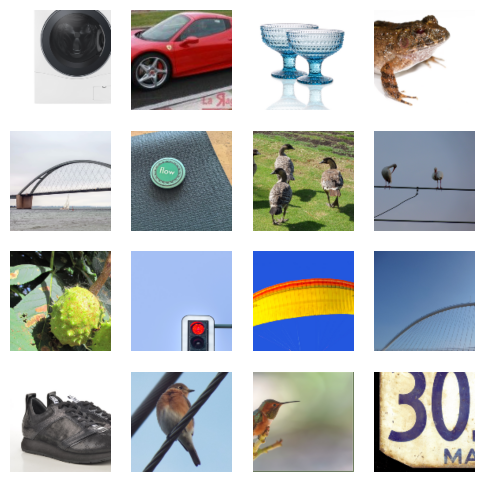

In [2]:
seed = 2025
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
device = torch.device(f"cuda:0")
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize((128, 128))
])

trainloader = torch.utils.data.DataLoader(ImageNet(transforms=transform), batch_size=16, shuffle=True)
model = get_resnet18().to(device)
loss_func = torch.nn.CrossEntropyLoss()
data, label = next(iter(trainloader))
data, label = data.to(device), label.to(device)
torchvision.utils.save_image(data, f"./real_imgs.png")
client_grads = get_client_gradient(data, label, model, torch.nn.CrossEntropyLoss())
client_grads = [grad.clone() for grad in client_grads]

data = upscale(data)
plot_images(data)

### 🚩 3. Attack for five times

In [3]:
psnrs = []

import statistics
def print_psnrs(psnrs):
    median_psnr = statistics.mean(psnrs)
    best_psnr = max(psnrs)
    print(f"BEST PSNR: {best_psnr:6.4f}")
    print(f"MEDIAN PSNR: {median_psnr:6.4f}")
    
    print("ALL PSNR: [", end="")
    for p in psnrs[0:-1]:
        print(f"{p:6.4f}, ", end="")
    print(f"{p:6.4f}]")

#### ⭕ 3.1 Times 1

| It: 1 | Loss: -14.6992 | Time:   5.04s |


| It: 1001 | Loss: -61.5192 | Time: 477.84s |


| It: 2001 | Loss: -61.8071 | Time: 473.44s |


| It: 3001 | Loss: -61.8777 | Time: 473.82s |


| It: 4001 | Loss: -61.9130 | Time: 472.33s |


| It: 5001 | Loss: -61.9375 | Time: 473.83s |


| It: 6001 | Loss: -61.9549 | Time: 472.10s |


| It: 7001 | Loss: -61.9674 | Time: 471.50s |


| It: 8001 | Loss: -61.9750 | Time: 471.34s |


| It: 9001 | Loss: -61.9784 | Time: 471.34s |


PSNR: 22.8272


<Figure size 400x300 with 0 Axes>

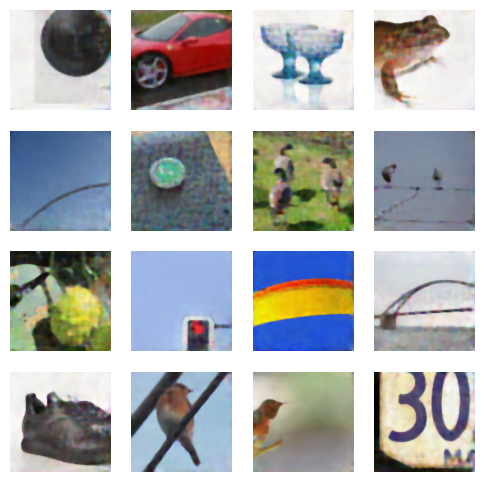

In [4]:
best_ones_PSNR = torch.zeros_like(data)
best_ones_SSIM = torch.zeros_like(data)
best_ones_LPIPS = torch.zeros_like(data)
recovered_images = FedLeak(client_grads, label, model, combine_loss, device=device)
best_ones_PSNR = update_best_ones(best_ones_PSNR, data, recovered_images, "PSNR")

psnr = compute_psnr(data, best_ones_PSNR, False).mean().item()
psnrs.append(psnr)
print(f"PSNR: {psnr:6.4f}")
plot_images(recovered_images)

#### ⭕ 3.2 Times 2

| It: 1 | Loss: -7.3972 | Time:   0.52s |


| It: 1001 | Loss: -61.4952 | Time: 474.00s |


| It: 2001 | Loss: -61.8000 | Time: 472.70s |


| It: 3001 | Loss: -61.8714 | Time: 473.27s |


| It: 4001 | Loss: -61.9118 | Time: 472.18s |


| It: 5001 | Loss: -61.9380 | Time: 472.27s |


| It: 6001 | Loss: -61.9541 | Time: 472.75s |


| It: 7001 | Loss: -61.9675 | Time: 474.61s |


| It: 8001 | Loss: -61.9748 | Time: 473.87s |


| It: 9001 | Loss: -61.9779 | Time: 473.48s |


PSNR: 22.0945


<Figure size 400x300 with 0 Axes>

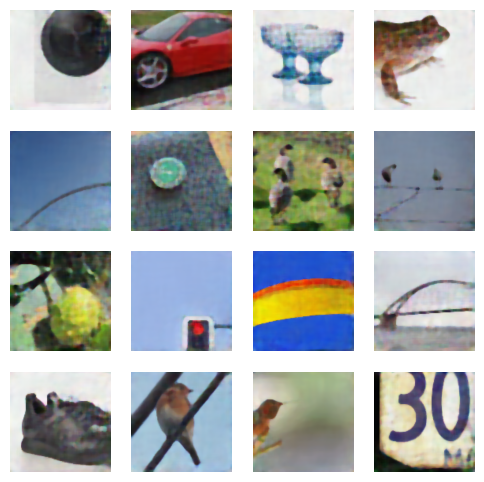

In [5]:
best_ones_PSNR = torch.zeros_like(data)
best_ones_SSIM = torch.zeros_like(data)
best_ones_LPIPS = torch.zeros_like(data)
recovered_images = FedLeak(client_grads, label, model, combine_loss, device=device)
best_ones_PSNR = update_best_ones(best_ones_PSNR, data, recovered_images, "PSNR")

psnr = compute_psnr(data, best_ones_PSNR, False).mean().item()
psnrs.append(psnr)
print(f"PSNR: {psnr:6.4f}")
plot_images(recovered_images)

#### ⭕ 3.3 Times 3

| It: 1 | Loss: -9.1300 | Time:   0.39s |


| It: 1001 | Loss: -61.2958 | Time: 471.70s |


| It: 2001 | Loss: -61.7637 | Time: 471.95s |


| It: 3001 | Loss: -61.8582 | Time: 472.94s |


| It: 4001 | Loss: -61.8988 | Time: 473.04s |


| It: 5001 | Loss: -61.9267 | Time: 470.51s |


| It: 6001 | Loss: -61.9470 | Time: 473.02s |


| It: 7001 | Loss: -61.9611 | Time: 473.01s |


| It: 8001 | Loss: -61.9700 | Time: 472.96s |


| It: 9001 | Loss: -61.9741 | Time: 473.53s |


PSNR: 22.9379


<Figure size 400x300 with 0 Axes>

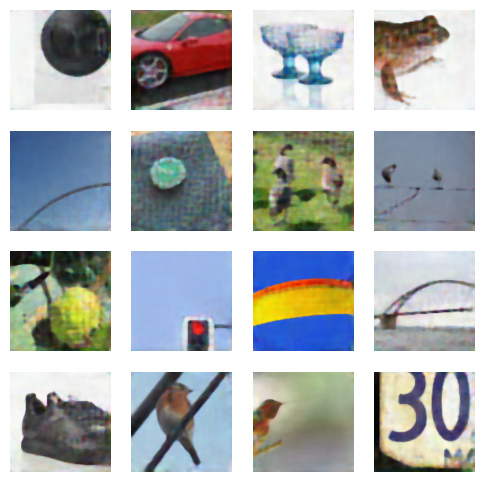

In [6]:
best_ones_PSNR = torch.zeros_like(data)
best_ones_SSIM = torch.zeros_like(data)
best_ones_LPIPS = torch.zeros_like(data)
recovered_images = FedLeak(client_grads, label, model, combine_loss, device=device)
best_ones_PSNR = update_best_ones(best_ones_PSNR, data, recovered_images, "PSNR")

psnr = compute_psnr(data, best_ones_PSNR, False).mean().item()
psnrs.append(psnr)
print(f"PSNR: {psnr:6.4f}")
plot_images(recovered_images)

#### ⭕ 3.4 Times 4

| It: 1 | Loss: -14.2615 | Time:   0.38s |


| It: 1001 | Loss: -61.4467 | Time: 473.96s |


| It: 2001 | Loss: -61.7759 | Time: 473.36s |


| It: 3001 | Loss: -61.8677 | Time: 469.28s |


| It: 4001 | Loss: -61.9088 | Time: 472.38s |


| It: 5001 | Loss: -61.9332 | Time: 470.69s |


| It: 6001 | Loss: -61.9516 | Time: 473.49s |


| It: 7001 | Loss: -61.9657 | Time: 472.21s |


| It: 8001 | Loss: -61.9734 | Time: 474.08s |


| It: 9001 | Loss: -61.9771 | Time: 469.67s |


PSNR: 22.4008


<Figure size 400x300 with 0 Axes>

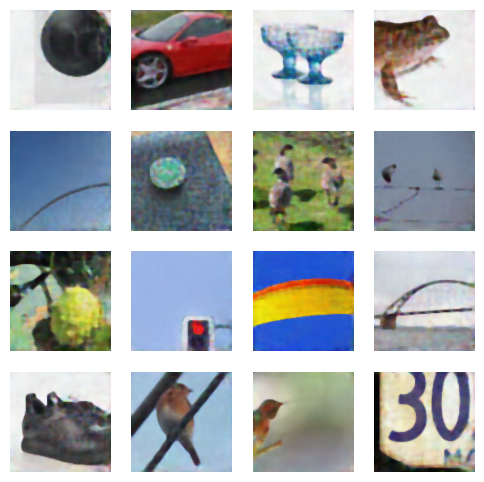

In [7]:
best_ones_PSNR = torch.zeros_like(data)
best_ones_SSIM = torch.zeros_like(data)
best_ones_LPIPS = torch.zeros_like(data)
recovered_images = FedLeak(client_grads, label, model, combine_loss, device=device)
best_ones_PSNR = update_best_ones(best_ones_PSNR, data, recovered_images, "PSNR")

psnr = compute_psnr(data, best_ones_PSNR, False).mean().item()
psnrs.append(psnr)
print(f"PSNR: {psnr:6.4f}")
plot_images(recovered_images)

#### ⭕ 3.5 Times 5

| It: 1 | Loss: -11.4636 | Time:   0.50s |


| It: 1001 | Loss: -61.4089 | Time: 471.19s |


| It: 2001 | Loss: -61.7794 | Time: 472.25s |


| It: 3001 | Loss: -61.8662 | Time: 473.10s |


| It: 4001 | Loss: -61.9009 | Time: 472.88s |


| It: 5001 | Loss: -61.9314 | Time: 472.73s |


| It: 6001 | Loss: -61.9497 | Time: 470.08s |


| It: 7001 | Loss: -61.9628 | Time: 470.95s |


| It: 8001 | Loss: -61.9714 | Time: 472.00s |


| It: 9001 | Loss: -61.9750 | Time: 470.82s |


PSNR: 22.0480


<Figure size 400x300 with 0 Axes>

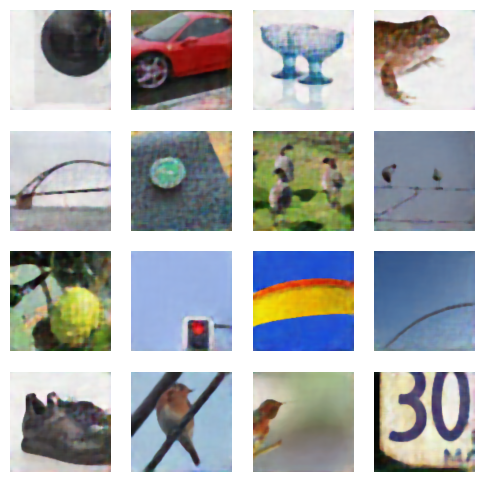

In [8]:
best_ones_PSNR = torch.zeros_like(data)
best_ones_SSIM = torch.zeros_like(data)
best_ones_LPIPS = torch.zeros_like(data)
recovered_images = FedLeak(client_grads, label, model, combine_loss, device=device)
best_ones_PSNR = update_best_ones(best_ones_PSNR, data, recovered_images, "PSNR")

psnr = compute_psnr(data, best_ones_PSNR, False).mean().item()
psnrs.append(psnr)
print(f"PSNR: {psnr:6.4f}")
plot_images(recovered_images)

### 🚩 4. Print PSNR for 5 times

Expected values in `./sanity_check_showcase.ipynb`:

- ***BEST PSNR***: 23.0200
- ***MEDIAN PSNR***: 22.4383
- ***ALL PSNR***: [23.0200, 22.7865, 22.1592, 22.0909, 22.0909]

In [9]:
print_psnrs(psnrs)

BEST PSNR: 22.9379
MEDIAN PSNR: 22.4617
ALL PSNR: [22.8272, 22.0945, 22.9379, 22.4008, 22.4008]
